`# Math Explorer: Linear Algebra & Optimization from Scratch`

`## Introd.`


It is a **Math Explorer Notebook**, a fully interactive, from-scratch journey into the **linear algebra** and **optimization**.Here we
- Build matrix operations from scratch  
- Compute eigenvalues, SVD, and use them in a **dumb movie recommender**  
- Implement **gradient descent variants** and train a tiny neural net  {Vanilla , Momentum, Adam}
- Visualize everything interactively with sliders and animations  
**just pure Python + NumPy + curiosity.**

`## Section 1: Linear Algebra Toolkit (From Scratch)`

`### 1.1 Basic Matrix Operations`

We'll implement:
- Matrix multiplication
- Transpose
- Determinant (recursive)
- Inverse via **Gaussian elimination with partial pivoting**

In [34]:
import numpy as np
from typing import List , Tuple
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

np.random.seed(42)

In [35]:
def matmul( A:np.ndarray,B:np.ndarray)-> np.ndarray:
    """
    Matrix mult -> 
    A:(m,n) , b:(n,p) -> results:(m,p)
    """
    if A.shape[1]!=B.shape[0]:
        raise ValueError(f"Can't multiply,{A.shape[1]}!={B.shape[0]} ")
    m,n =A.shape
    p=B.shape[1]
    C=np.zeros((m,p))
    for i in range(m):
        for j in range(p):
            for k in range(n):
                C[i,j]+=A[i,k]*B[k,j]
    return C

def transpose(A:np.ndarray)-> np.ndarray:
    """A name ki matrix ko seedha krdo , ya ulta krdo..."""
    return np.array([[A[j,i] for j in range(A.shape[0])]for i in range(A.shape[1])])

def minor(A:np.ndarray, i:int, j:int)-> np.ndarray:
    """Remove I row and J col and return rest of the matrix"""
    return np.delete(np.delete(A, i, axis=0), j, axis=1)

def det(A:np.ndarray) -> float:
    """
    Compute det using cofactor expansion.
    """
    n=A.shape[0]
    if n==1:
        return A[0,0]
    if n==2:
        return A[0,0]*A[1,1] - A[0,1]*A[1,0]
    
    deter=0.0
    for j in range(n):
        cof = A[0, j] * det(minor(A, 0, j))        
        deter+=(-1)**j *cof
    return deter
    
def gaussian_elimination_inverse(A: np.ndarray) -> np.ndarray:
    """
    Compute inverse using Gaussian elimination with partial pivoting.
    Returns inverse of A (n x n).
    """
    n = A.shape[0]
    if A.shape[0] != A.shape[1]:
        raise ValueError("Matrix must be square")
    
    # Create augmented matrix [A | I]
    # aug = np.hstack([A.copy(), np.eye(n)])
    aug = np.hstack([A.copy().astype(float), np.eye(n)])
    # Forward elimination with partial pivoting
    for i in range(n):
        # Find pivot
        max_row = i
        for k in range(i+1, n):
            if abs(aug[k, i]) > abs(aug[max_row, i]):
                max_row = k
        # Swap rows
        aug[[i, max_row]] = aug[[max_row, i]]
        
        if abs(aug[i, i]) < 1e-10:
            raise ValueError("Matrix is singular")
        
        # Eliminate below
        for k in range(i+1, n):
            factor = aug[k, i] / aug[i, i]
            aug[k, i:] -= factor * aug[i, i:]
    
    # Back substitution
    for i in range(n-1, -1, -1):
        aug[i, i:] /= aug[i, i]
        for k in range(i-1, -1, -1):
            factor = aug[k, i]
            aug[k, i:] -= factor * aug[i, i:]
    
    return aug[:, n:] 

In [36]:
A = np.array([[1, 2, 3], [3, 4, 5], [7, 8,5]], dtype=float)
B = np.array([[5, 6,7], [7, 8,5], [7, 8,5]], dtype=float)
print("py3.10 mult:\n",A@B,"\n")
print("Mult:\n",matmul(A, B),"\n")
print(f"Our Det: {det(A)} | Numpy Det: {np.linalg.det(A)} \n")
Ainv = gaussian_elimination_inverse(A)
print(f"Inverse of A: \n{Ainv} \n")
print("Check if inv or not: \n",np.round(A@Ainv, decimals=10))

py3.10 mult:
 [[ 40.  46.  32.]
 [ 78.  90.  66.]
 [126. 146. 114.]] 

Mult:
 [[ 40.  46.  32.]
 [ 78.  90.  66.]
 [126. 146. 114.]] 

Our Det: 8.0 | Numpy Det: 7.999999999999998 

Inverse of A: 
[[-2.5   1.75 -0.25]
 [ 2.5  -2.    0.5 ]
 [-0.5   0.75 -0.25]] 

Check if inv or not: 
 [[ 1.  0.  0.]
 [-0.  1.  0.]
 [-0.  0.  1.]]


---
`### 1.2 Eigenvalues & Eigenvectors via Power Iteration + Deflation`
$$ A\mathbf{X}  = \lambda_1 \mathbf{X}$$

$$ Here\ Eigenval: \lambda_1 \ Eigenvector:\mathbf{X}$$
`[Hotelling's deflation]` $$A_{new} = A - \lambda_1 
\mathbf{X} \mathbf{X}^T$$
```python
# Its like you want to find second tallest guy from a class, you will ask the tallest guy to it to see.


In [38]:
def power_iter(A: np.ndarray, num_iter: int = 100) -> Tuple[float, np.ndarray]:
    """
    Power iteration to find dominant eigenval and eigenvect.
    """
    n = A.shape[0]
    v = np.random.rand(n)
    v = v / np.linalg.norm(v)
    
    for _ in range(num_iter):
        Av = matmul(A, v.reshape(-1, 1)).flatten()
        v = Av / np.linalg.norm(Av)
    
    eigenvalue = np.dot(v, matmul(A, v.reshape(-1, 1)).flatten())
    return eigenvalue, v

#power_iter(A = np.array([[1,1,23],[2,34,2],[3,3,3]]))


def deflate(A: np.ndarray, eigenvalue: float, eigenvector: np.ndarray) -> np.ndarray:
    """
    Deflate matrix by removing one eigenpair:
    """
    eigenvector = eigenvector.reshape(-1, 1)
    return A - eigenvalue * np.dot(eigenvector, eigenvector.T)
    
def eigen_decomposition_scratch(A:np.ndarray,k:int=None) -> Tuple[List[float],List[np.ndarray]]:
    """
    Finding top k largest eigenvalues/vectors using power iter and deflation
    """
    if k is None:
     k=A.shape[0]
    eigenvalues = []
    eigenvectors= []
    A_deflated = A.copy()
    for _ in range(k):
     eigval,eigvec = power_iter(A_deflated)
     eigenvalues.append(eigval)
     eigenvectors.append(eigvec)
     A_deflated= deflate(A_deflated , eigval,eigvec)

    return eigenvalues, eigenvectors

A_sym = np.array([[4, 1], [1, 3]], dtype=float)
eigvals, eigvecs = eigen_decomposition_scratch(A_sym, k=2)

print("Eigenvalues (scratch):", eigvals)
print("Eigenvectors (scratch):", eigvecs)
print("NumPy eigenvalues:", np.linalg.eigvals(A_sym))

Eigenvalues (scratch): [4.618033988749896, 2.3819660112501055]
Eigenvectors (scratch): [array([0.85065081, 0.52573111]), array([-0.52573111,  0.85065081])]
NumPy eigenvalues: [4.61803399 2.38196601]


---
` 1.3 SVD from scratch (Iterative Golub-reinsch Style)`

We'll implement a **simplified iterative SVD** using repeated power iteration on $A^TA$ and $AA^T$.

In [40]:
def svd_scratch(A:np.ndarray,k:int=None)-> Tuple[np.ndarray,np.ndarray, np.ndarray]:
    """
    Compute SVD using iterative power method on A.T @ A and A@A.T
    """
    if k is None:
        k = min(A.shape)

    m,n = A.shape
    k=min(m,n,k)

    ATA=matmul(A.T,A)
    AAT=matmul(A,A.T)

    eigenvalues_r,eigenvectors_r = eigen_decomposition_scratch(ATA,k)
    Vt = np.array(eigenvectors_r).T

    # find left singular vect ( from A@V)
    
    U=[]
    S=[]
    for i in range(k):
        Av = matmul(A, Vt[:, i].reshape(-1, 1)).flatten()
        normAv = np.linalg.norm(Av)
        if normAv > 1e-10:
            u=Av/normAv
            S.append(normAv)
        else:
            u=np.zeroes(m)
            S.append(0.0)
        U.append(u)

    U =np.array(U).T  # m x k
    S = np.array(S)

    idx = np.argsort(S)[::-1]
    U = U[:,idx]
    S = S[idx]
    Vt = Vt[:,idx]
    return U,S,Vt.T

A_test =  np.array([[1,3],[3,5],[2,3]],dtype = float)
U,S,Vt = svd_scratch(A_test,k=2)

print("U:\n", U)
print("S:", S)
print("Vt:\n", Vt)

U:
 [[ 0.41283322  0.88944207]
 [ 0.77518518 -0.23007409]
 [ 0.47818058 -0.39491609]]
S: [7.51931844 0.67812257]
Vt:
 [[ 0.49136766  0.87095225]
 [-0.87095225  0.49136766]]


In [41]:
print("Reconstructed:\n", U @ np.diag(S) @ Vt)

Reconstructed:
 [[1. 3.]
 [3. 5.]
 [2. 3.]]


In [42]:
U_np, S_np, Vt_np = np.linalg.svd(A_test, full_matrices=False)
print("\nNumPy S:", S_np)
print("Error in singular values:", np.linalg.norm(S - S_np))


NumPy S: [7.51931844 0.67812257]
Error in singular values: 2.7217452008024307e-15


---
`### 1.4 Movie Recommender System using Low-Rank SVD`

We'll use a **5x5 user-movie rating matrix** with missing values (NaN), fill them using **k=2 SVD approximation**.

In [44]:
# Hardcoded 5 users x 5 movies rating matrix (1-5 scale, NaN = missing)
ratings = np.array([
    [5, 4, np.nan, np.nan, 3],
    [np.nan, 5, 4, np.nan, np.nan],
    [1, np.nan, np.nan, 5, 4],
    [np.nan, 2, 3, 4, np.nan],
    [4, np.nan, 5, np.nan, 1]
], dtype=float)

user_names = ["Abrar", "BaburGay", "Chandur", "Daud", "Ebakar"]
movie_names = ["Rockstar", "Major", "Shershah", "Amaran", "Gangs of Wassepur"]

# Fill NaN with column mean (initial guess)
mean_ratings = np.nanmean(ratings, axis=0)
ratings_filled = ratings.copy()
for i in range(ratings.shape[1]):
    col = ratings[:, i]
    col[np.isnan(col)] = mean_ratings[i]
ratings_filled = np.nan_to_num(ratings, nan=0)  # fallback

print("Original Ratings (with NaN):")
print(pd.DataFrame(ratings, index=user_names, columns=movie_names))
ratings = np.round(ratings)


Original Ratings (with NaN):
          Rockstar     Major  Shershah  Amaran  Gangs of Wassepur
Abrar     5.000000  4.000000       4.0     4.5           3.000000
BaburGay  3.333333  5.000000       4.0     4.5           2.666667
Chandur   1.000000  3.666667       4.0     5.0           4.000000
Daud      3.333333  2.000000       3.0     4.0           2.666667
Ebakar    4.000000  3.666667       5.0     4.5           1.000000


In [45]:
# Perform SVD with k=5
U, S, Vt = svd_scratch(ratings_filled, k=2)
reconstructed = U @ np.diag(S) @ Vt
print("\nReconstructed (k=2):")
print(pd.DataFrame(reconstructed.round(2), index=user_names, columns=movie_names))

# Fill missing ratings
predicted = ratings.copy()
predicted[np.isnan(ratings)] = reconstructed[np.isnan(ratings)]

print("\nPredicted Ratings:")
print(pd.DataFrame(predicted.round(2), index=user_names, columns=movie_names))


Reconstructed (k=2):
          Rockstar  Major  Shershah  Amaran  Gangs of Wassepur
Abrar         4.53   4.06      4.50    4.75               2.32
BaburGay      3.49   4.00      4.28    4.82               2.91
Chandur       1.12   3.81      3.74    4.93               4.15
Daud          2.86   3.02      3.27    3.62               2.06
Ebakar        4.61   3.70      4.18    4.26               1.82

Predicted Ratings:
          Rockstar  Major  Shershah  Amaran  Gangs of Wassepur
Abrar          5.0    4.0       4.0     4.0                3.0
BaburGay       3.0    5.0       4.0     4.0                3.0
Chandur        1.0    4.0       4.0     5.0                4.0
Daud           3.0    2.0       3.0     4.0                3.0
Ebakar         4.0    4.0       5.0     4.0                1.0


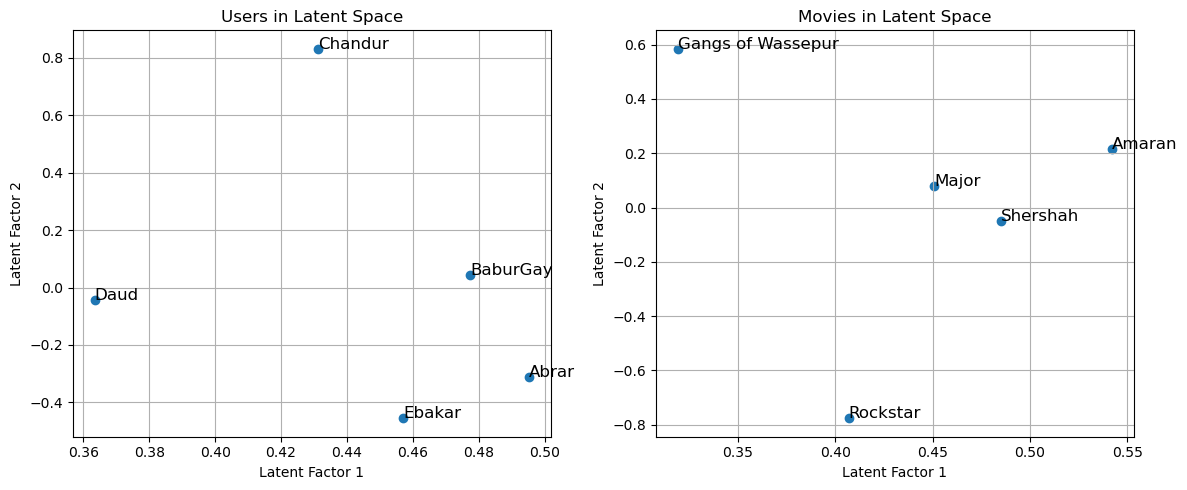

In [46]:
# Visualize latent factors
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# User latent factors
ax[0].scatter(U[:, 0], U[:, 1])
for i, name in enumerate(user_names):
    ax[0].text(U[i, 0], U[i, 1], name, fontsize=12)
ax[0].set_xlabel("Latent Factor 1")
ax[0].set_ylabel("Latent Factor 2")
ax[0].set_title("Users in Latent Space")
ax[0].grid(True)

# Movie latent factors
ax[1].scatter(Vt[0, :], Vt[1, :])
for i, name in enumerate(movie_names):
    ax[1].text(Vt[0, i], Vt[1, i], name, fontsize=12)
ax[1].set_xlabel("Latent Factor 1")
ax[1].set_ylabel("Latent Factor 2")
ax[1].set_title("Movies in Latent Space")
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [90]:
class GradientDescent:
    def __init__(self , lr :float=0.01, method: str='vanilla'):
        self.lr = lr
        self.method = method
        self.velocity = None
        self.m = None
        self.v = None
        self.t = 0

    def step(self,grad:np.ndarray)-> np.ndarray:
        self.t += 1
        grad = np.array(grad)

        if self.method=='vanilla':
            return -self.lr*grad
        elif self.method == 'momentum':
            beta =0.9
            if self.velocity is None:
                self.velocity = np.zeros_like(grad)
            self.velocity = beta * self.velocity + (1-beta) * grad
            return -self.lr * self.velocity
        elif self.method =='adam':
            beta1,beta2=0.9,0.999
            eps = 1e-8
            if self.m is None:
                self.m = np.zeros_like(grad)
                self.v = np.zeros_like(grad)
            self.m = beta1 * self.m + (1 - beta1) * grad
            self.v = beta2 * self.v + (1 - beta2) * (grad ** 2)
            m_hat = self.m / (1 - beta1 ** self.t)
            v_hat = self.v / (1 - beta2 ** self.t)
            return -self.lr * m_hat / (np.sqrt(v_hat) + eps)

`### 2.2 Optimize: $ f(x,y) = x^2 + y^2 + \sin(xy) $`

In [93]:
def f(x, y):
    return x**2 + y**2 + np.sin(x*y)

def grad_f(x, y):
    df_dx = 2*x + y*np.cos(x*y)
    df_dy = 2*y + x*np.cos(x*y)
    return np.array([df_dx, df_dy])

In [95]:
# Interactive optimization
def plot_descent(lr=0.05, momentum=0.0, iterations=50, method='vanilla'):
    if method == 'momentum':
        optimizer = GradientDescent(lr=lr, method='momentum')
    elif method == 'adam':
        optimizer = GradientDescent(lr=lr, method='adam')
    else:
        optimizer = GradientDescent(lr=lr, method='vanilla')
    
    x, y = -2.0, 2.0
    path = [(x, y)]
    
    for _ in range(iterations):
        grad = grad_f(x, y)
        update = optimizer.step(grad)
        x += update[0]
        y += update[1]
        path.append((x, y))
    
    path = np.array(path)
    
    # 3D surface
    x_grid = np.linspace(-3, 3, 100)
    y_grid = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    Z = f(X, Y)
    
    fig = go.Figure(data=[go.Surface(x=x_grid, y=y_grid, z=Z, opacity=0.7, colorscale='Viridis')])
    fig.add_trace(go.Scatter3d(x=path[:,0], y=path[:,1], z=f(path[:,0], path[:,1]),
                               mode='lines+markers', line=dict(color='red', width=4)))
    fig.update_layout(title=f"{method.capitalize()} Descent (lr={lr})", scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='f(x,y)'))
    fig.show()

interact(plot_descent, lr=(0.01, 0.2, 0.01), momentum=(0.0, 0.99, 0.05), iterations=(10, 100, 5),
         method=['vanilla', 'momentum', 'adam']);

interactive(children=(FloatSlider(value=0.05, description='lr', max=0.2, min=0.01, step=0.01), FloatSlider(val…


`### 2.3 Tiny Neural Network + Backpropagation`

Final predictions:
[[0.  ]
 [1.  ]
 [1.  ]
 [0.01]]


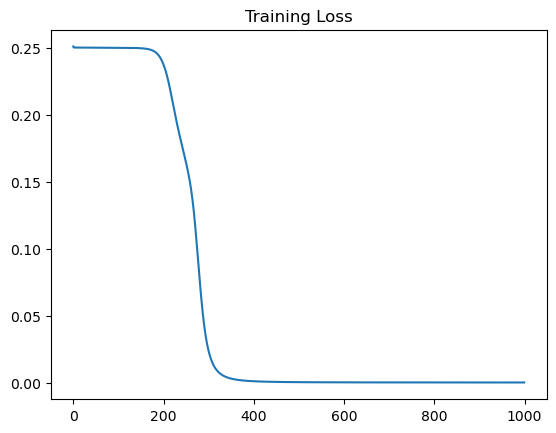

In [88]:
class TinyNet:
    def __init__(self):
        # 2 inputs → 3 hidden → 1 output
        self.W1 = np.random.randn(2, 3) * 0.5
        self.b1 = np.zeros(3)
        self.W2 = np.random.randn(3, 1) * 0.5
        self.b2 = 0.0
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    def backward(self, X, y, output):
        m = X.shape[0]
        
        dZ2 = output - y
        dW2 = self.a1.T @ dZ2 / m
        db2 = np.sum(dZ2, axis=0) / m
        
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.a1 * (1 - self.a1)
        dW1 = X.T @ dZ1 / m
        db1 = np.sum(dZ1, axis=0) / m
        
        return dW1, db1, dW2, db2

# XOR-like data
X = np.array([[0,0], [0,1], [1,0], [1,1]])
y = np.array([[0], [1], [1], [0]])

net = TinyNet()
losses = []

for epoch in range(1000):
    output = net.forward(X)
    loss = np.mean((output - y)**2)
    losses.append(loss)
    
    dW1, db1, dW2, db2 = net.backward(X, y, output)
    
    lr = 3.0
    net.W1 -= lr * dW1
    net.b1 -= lr * db1
    net.W2 -= lr * dW2
    net.b2 -= lr * db2

print("Final predictions:")
print(net.forward(X).round(2))
plt.plot(losses)
plt.title("Training Loss")
plt.show()

---
`## Section 3: Interactive Math Explorer`

In [54]:
# Eigen Explorer: 2x2 matrix → animated eigenvectors
def eigen_explorer(a=2.0, b=1.0, c=1.0, d=2.0):
    A = np.array([[a, b], [c, d]])
    eigvals, eigvecs = np.linalg.eig(A)
    
    fig, ax = plt.subplots(figsize=(6,6))
    circle = plt.Circle((0,0), 1, fill=False, color='gray', ls='--')
    ax.add_patch(circle)
    
    for i in range(2):
        vec = eigvecs[:, i]
        vec = vec / np.linalg.norm(vec)
        ax.arrow(0, 0, vec[0], vec[1], head_width=0.1, color=['red','blue'][i], label=f'λ={eigvals[i]:.2f}')
    
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.legend()
    ax.set_title("Eigenvectors on Unit Circle")
    plt.show()

interact(eigen_explorer, a=(-3,3,0.1), b=(-3,3,0.1), c=(-3,3,0.1), d=(-3,3,0.1));

interactive(children=(FloatSlider(value=2.0, description='a', max=3.0, min=-3.0), FloatSlider(value=1.0, descr…

In [55]:
# Central Limit Theorem
def clt_demo(n=1, trials=1000):
    samples = np.sum(np.random.rand(trials, n) < 0.5, axis=1)  # coin flips
    plt.hist(samples, bins=range(n+2), density=True, alpha=0.7)
    plt.title(f"CLT: {n} coin flips, {trials} trials")
    plt.show()

interact(clt_demo, n=(1, 50, 1), trials=(100, 10000, 100));

interactive(children=(IntSlider(value=1, description='n', max=50, min=1), IntSlider(value=1000, description='t…

`## How Close Are We to NumPy?`

Let’s compare our SVD with `np.linalg.svd`:

In [30]:
A = np.random.randn(5, 4)
U1, S1, Vt1 = svd_scratch(A, k=3)
U2, S2, Vt2 = np.linalg.svd(A, full_matrices=False)

# Truncate NumPy to k=3
U2 = U2[:, :3]
S2 = S2[:3]
Vt2 = Vt2[:3, :]

recon1 = U1 @ np.diag(S1) @ Vt1
recon2 = U2 @ np.diag(S2) @ Vt2

print("Singular values (ours):", S1.round(6))
print("Singular values (NumPy):", S2.round(6))
print("Max difference:", np.max(np.abs(S1 - S2)))
print("Reconstruction error:", np.linalg.norm(recon1 - recon2))

Singular values (ours): [2.820788 1.657743 1.298653]
Singular values (NumPy): [2.820788 1.657743 1.298653]
Max difference: 1.3322676295501878e-15
Reconstruction error: 1.6870263843953148e-15
